In [1]:
from copy import deepcopy
from typing import List

import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

from src.models.geometric_figure import GeometricFigure
from src.services.geometric_figure import (get_geometric_figures,
                                           get_input_and_output,
                                           plot_geometric_figures,
                                           prediction_to_category)

In [2]:
IMAGE_SIZE = (512, 512)
TEST_RATIO = 0.2
DATA_VERSION = '2023-04-03'

In [3]:
geometric_figures: List[GeometricFigure] = get_geometric_figures(f'data/{DATA_VERSION}', IMAGE_SIZE, memorize=True)
print(f'Loaded {len(geometric_figures)} geometric figures')

Loaded 660 geometric figures


In [4]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    keras.layers.Lambda(lambda x: x[..., 1:2]),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 512, 512, 1)       0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               33554560  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 33,564,995
Trainable params: 33,564,995
Non-trainable params: 0
____________________________________________

In [5]:
shuffled_geometric_figures: List[GeometricFigure] = deepcopy(geometric_figures)
np.random.shuffle(shuffled_geometric_figures)

x, y = zip(*[get_input_and_output(gf) for gf in shuffled_geometric_figures])
x = np.array(x)
y = np.array(y)

test_size = int(len(x) * TEST_RATIO)
x_train, x_test = x[:-test_size], x[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

In [6]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
17/17 [==============================] - 8s 192ms/step - loss: 25.5132 - accuracy: 0.3314: 2s - loss: 38.5335 - accura - ETA: 0s - loss: 29.7514 - accuracy: 0
Epoch 2/20
17/17 [==============================] - 3s 189ms/step - loss: 12.7594 - accuracy: 0.3845
Epoch 3/20
17/17 [==============================] - 3s 190ms/step - loss: 9.0542 - accuracy: 0.4527
Epoch 4/20
17/17 [==============================] - 3s 198ms/step - loss: 2.9647 - accuracy: 0.5606
Epoch 5/20
17/17 [==============================] - 3s 193ms/step - loss: 3.5913 - accuracy: 0.5322
Epoch 6/20
17/17 [==============================] - 3s 191ms/step - loss: 2.8051 - accuracy: 0.6212
Epoch 7/20
17/17 [==============================] - 3s 193ms/step - loss: 2.8080 - accuracy: 0.5341
Epoch 8/20
17/17 [==============================] - 3s 192ms/step - loss: 2.5572 - accuracy: 0.5985
Epoch 9/20
17/17 [==============================] - 3s 192ms/step - loss: 1.2710 - accuracy: 0.7102
Epoch 10/20
17/17 [==========

In [7]:
model.evaluate(x_test, y_test)

5/5 [==============================] - 1s 57ms/step - loss: 1.8257 - accuracy: 0.6364


[1.8256863355636597, 0.6363636255264282]

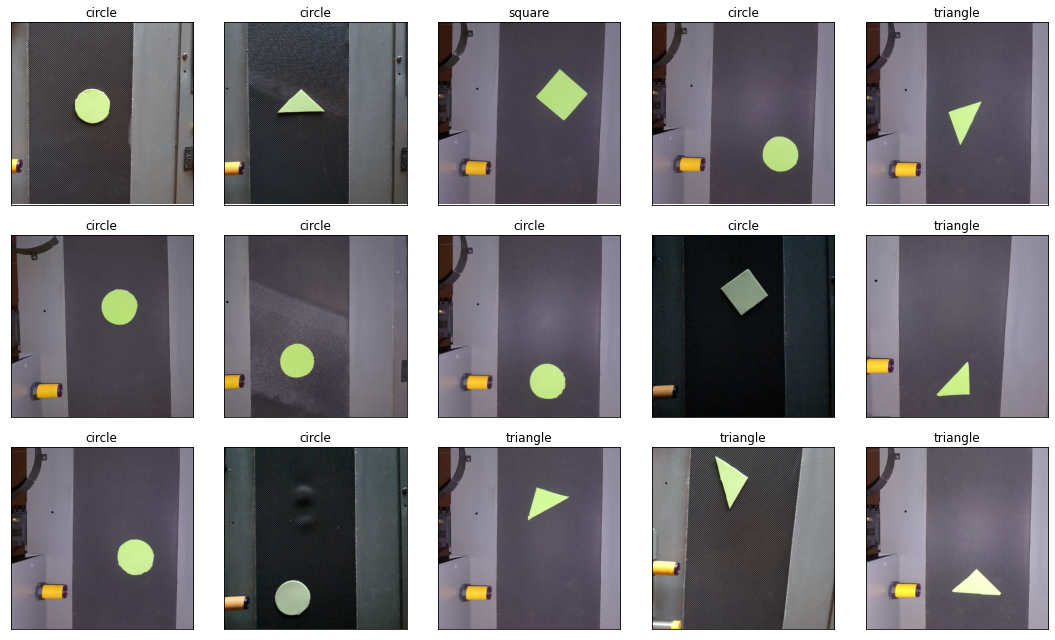

In [8]:
number_of_plots = 15
random_geometric_figures = deepcopy([geometric_figures[i] for i in np.random.randint(0, len(geometric_figures), number_of_plots)])
for gf in random_geometric_figures:
    x, y = get_input_and_output(gf)
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    category = prediction_to_category(y_pred)
    gf['category'] = category
plot_geometric_figures(random_geometric_figures, columns=5, plot_size=3)
plt.show()

In [9]:
model.save('data/geometric_figure_classifier.h5')